In [ ]:
install.packages("caret") #데이터 분할
install.packages("pROC")
install.packages("ggplot2")
install.packages("showtext")
install.packages("rpart")
install.packages("tidymodels")
install.packages("randomForest")
install.packages("rsample")
install.packages("car")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sysfonts’, ‘showtextdb’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘lhs’, ‘DiceDesign’, ‘sfd’, ‘patchwork’, ‘furrr’, ‘slider’, ‘doFuture’, ‘GPfit’, ‘m

In [ ]:
library(caret)
library(ggplot2)
library(showtext)
showtext_auto()
library(tidyverse)
library(rpart)
library(tidymodels)
library(randomForest)
library(rsample)
library(car)
library(dplyr)
library(data.table)
library(repr) # 출력 그래프 크기 변경
options(repr.plot.width=7, repr.plot.height=7)

In [ ]:
depress_raw <- fread("depression_data_teampro.csv") %>%
  as_tibble()

# 데이터 전처리

In [ ]:
# 원본 데이터에서 비율 조정
set.seed(31)

# Yes와 No 비율 조정
yes_data <- depress_raw %>%
  filter(`History of depression` == "Yes") %>%
  sample_frac(0.7 / mean(depress_raw$`History of depression` == "Yes"),1) # Yes 데이터 비율 조정

no_data <- depress_raw %>%
  filter(`History of depression` == "No") %>%
  sample_frac(0.3 / mean(depress_raw$`History of depression` == "No"),1) # No 데이터 비율 조정
# 70% Yes, 30% No 데이터 결합
balanced_data <- bind_rows(yes_data, no_data)

# 층화 샘플링 (20,000개 추출)
stratified_sample <- initial_split(balanced_data, prop = 20000 / nrow(balanced_data), strata = "History of depression")
sample_data <- training(stratified_sample)

# 추출된 표본 비율 확인
prop.table(table(sample_data$`History of depression`))

head(sample_data)

depress_raw <- sample_data


      No      Yes 
0.299965 0.700035 

Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of depression,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Joshua Rodriguez,72,Married,Master's Degree,2,Non-smoker,Sedentary,Employed,151892.08,Low,Moderate,Poor,No,Yes,Yes,No
Faith Fleming,22,Single,Bachelor's Degree,0,Former,Sedentary,Unemployed,8256.77,High,Unhealthy,Poor,No,No,Yes,Yes
John Frank,66,Married,Master's Degree,3,Non-smoker,Sedentary,Unemployed,785.01,Low,Moderate,Fair,No,Yes,Yes,Yes
David Hughes,62,Married,Master's Degree,2,Former,Sedentary,Unemployed,24479.14,Low,Moderate,Fair,No,No,No,No
Melanie Brown,26,Single,Associate Degree,0,Non-smoker,Active,Unemployed,11321.18,High,Unhealthy,Poor,No,No,No,Yes
Stephen Morales,57,Married,High School,1,Non-smoker,Sedentary,Employed,36847.85,Moderate,Unhealthy,Poor,No,Yes,No,No


In [ ]:
# Name 삭제
depress_raw <- depress_raw %>%
  select(-Name)

# 나이 변수 범주화
depress_raw <- depress_raw %>%
  mutate(
    Age = case_when(
      Age >= 18 & Age <= 39 ~ "청년",
      Age >= 40 & Age <= 59 ~ "중년",
      Age >= 60 ~ "노년"
    )
  )

# 소득 사분위수 계산
income_quartiles <- quantile(depress_raw$Income, probs = c(0.25, 0.75))

# 소득 범주화
depress_raw <- depress_raw %>%
  mutate(
    Income = case_when(
      Income < income_quartiles[1] ~ "저소득층",
      Income >= income_quartiles[1] & Income <= income_quartiles[2] ~ "중소득층",
      Income > income_quartiles[2] ~ "고소득층"
    )
)

In [ ]:
# 원핫 인코딩 적용
depress <- depress_raw
dummies <- dummyVars("~ `Education Level` + `Marital Status` + `Smoking Status` + Income +
`Dietary Habits` + `Sleep Patterns` + `Physical Activity Level`", data = depress)
depress_dummies <- predict(dummies, newdata = depress)

In [ ]:
# 라벨 인코딩
depress$`Alcohol Consumption` <- factor(depress$`Alcohol Consumption`, levels = c("Low", "Moderate", "High"))
depress$`Alcohol Consumption` <- as.integer(depress$`Alcohol Consumption`) - 1  # 0, 1, 2로 변환

depress$Age <- factor(depress$Age, levels = c("청년", "중년", "노년"))
depress$Age <- as.integer(depress$Age) - 1  # 0, 1, 2로 변경

#depress$`Physical Activity Level` <- factor(depress$`Physical Activity Level`, levels = c("Sedentary", "Moderate", "Active"))
#depress$`Physical Activity Level` <- as.integer(depress$`Physical Activity Level`) - 1  # 0, 1, 2로 변환

#depress$`Dietary Habits` <- factor(depress$`Dietary Habits`, levels = c("Unhealthy", "Moderate", "Healthy"))
#depress$`Dietary Habits` <- as.integer(depress$`Dietary Habits`) - 1  # 0, 1, 2로 변환

#depress$`Sleep Patterns` <- factor(depress$`Sleep Patterns`, levels = c("Poor", "Fair", "Good"))
#depress$`Sleep Patterns` <- as.integer(depress$`Sleep Patterns`) - 1  # 0, 1, 2로 변환

In [ ]:
# 이진분리
depress$`History of Substance Abuse` <- ifelse(depress$`History of Substance Abuse` == "Yes", 1, 0)
depress$`Family History of Depression` <- ifelse(depress$`Family History of Depression` == "Yes",1,0)
depress$`Chronic Medical Conditions` <- ifelse(depress$`Chronic Medical Conditions` == "Yes",1,0)
depress$`History of depression` <- ifelse(depress$`History of depression` == "Yes",1,0)
depress$`Employment Status` <- ifelse(depress$`Employment Status` == "Employed",1,0)

In [ ]:
# 이진분리 후 펙터화
depress <- depress %>%
  mutate_at(c("History of Substance Abuse",
              "Chronic Medical Conditions",
              "Family History of Depression",
              "History of depression", "Employment Status"
              ),
            as.factor)

depress <- depress %>%
  select(-c(`Marital Status`, `Education Level`, `Smoking Status`,
Income, `Dietary Habits`, `Sleep Patterns`, `Physical Activity Level`))

In [ ]:
depress <- cbind(depress,depress_dummies)
colnames(depress) <- make.names(colnames(depress))
str(depress)

'data.frame':	19999 obs. of  32 variables:
 $ Age                                : num  2 0 2 2 0 1 1 2 1 2 ...
 $ Number.of.Children                 : int  2 0 3 2 0 1 3 1 0 3 ...
 $ Employment.Status                  : Factor w/ 2 levels "0","1": 2 1 1 1 1 2 2 2 2 1 ...
 $ Alcohol.Consumption                : num  0 2 0 0 2 1 1 1 1 0 ...
 $ History.of.depression              : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ History.of.Substance.Abuse         : Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 2 1 1 ...
 $ Family.History.of.Depression       : Factor w/ 2 levels "0","1": 2 2 2 1 1 1 2 1 1 1 ...
 $ Chronic.Medical.Conditions         : Factor w/ 2 levels "0","1": 1 2 2 1 2 1 1 2 1 1 ...
 $ X.Education.Level.Associate.Degree : num  0 0 0 0 1 0 1 0 0 0 ...
 $ X.Education.Level.Bachelor.s.Degree: num  0 1 0 0 0 0 0 0 0 0 ...
 $ X.Education.Level.High.School      : num  0 0 0 0 0 1 0 0 0 1 ...
 $ X.Education.Level.Master.s.Degree  : num  1 0 1 1 0 0 0 1 1 0 ...
 $ X.Education

In [ ]:
# 훈련용, 검증용 데이터 나누기
# 시드 고정
set.seed(31)
index <- caret::createDataPartition(y = depress$History.of.depression, p = 0.9, list = FALSE)
# 훈련 데이터 (90%)
train_depress <- depress[index, ]
# 검증 데이터 (10%)
test_depress <- depress[-index, ]

# 데이터 시각화

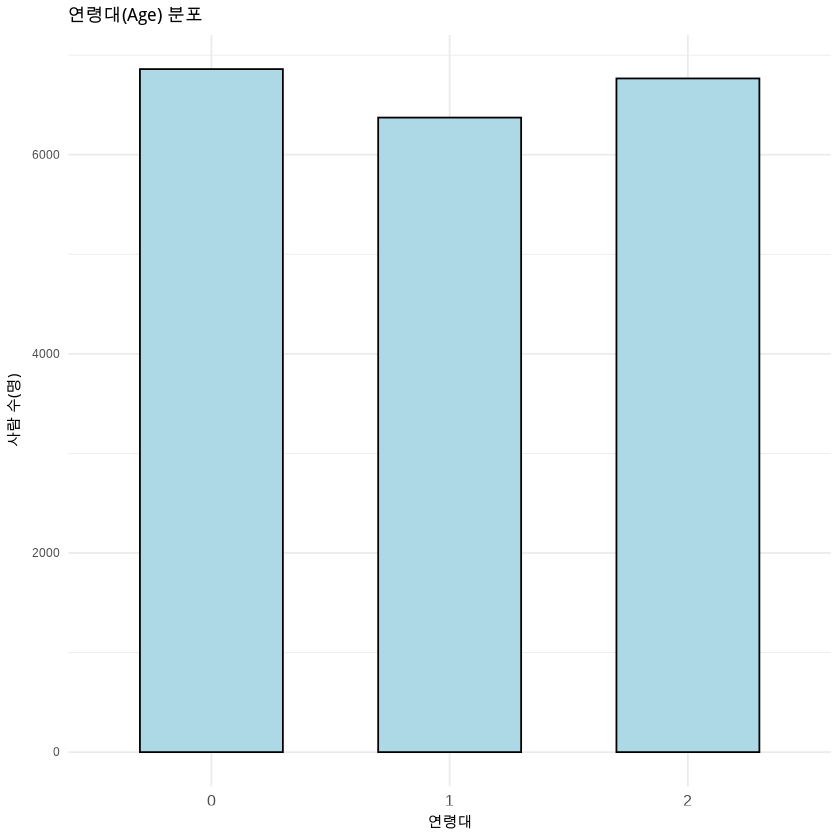

In [ ]:
# 'Age' 변수의 빈도 계산
age_table <- table(depress$Age)

# 'age_table'을 데이터프레임으로 변환
age_df <- as.data.frame(age_table)

# 컬럼 이름 수정
colnames(age_df) <- c("Age", "Frequency")

# Barplot 시각화
ggplot(age_df, aes(x = Age, y = Frequency)) +
  geom_bar(stat = "identity", fill = "lightblue", color = "black",width = 0.6) +
  theme_minimal() +
  labs(
    title = "연령대(Age) 분포",
    x = "연령대",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

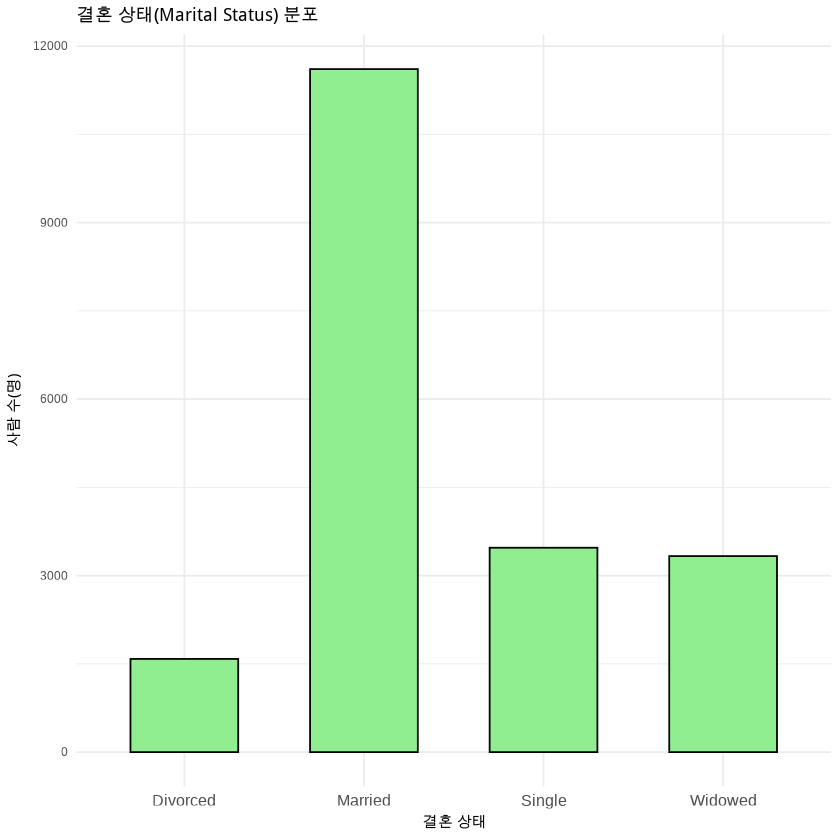

In [ ]:
# 'Marital Status' 변수의 빈도 계산
marital_status_table <- table(depress$`Marital Status`)

# 'marital_status_table'을 데이터프레임으로 변환
marital_status_df <- as.data.frame(marital_status_table)

# 컬럼 이름 수정
colnames(marital_status_df) <- c("Marital Status", "Frequency")

# Barplot 시각화
ggplot(marital_status_df, aes(x = `Marital Status`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "lightgreen", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "결혼 상태(Marital Status) 분포",
    x = "결혼 상태",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Education Level' 변수의 빈도 계산
education_level_table <- table(depress$`Education Level`)

# 'education_level_table'을 데이터프레임으로 변환
education_level_df <- as.data.frame(education_level_table)

# 컬럼 이름 수정
colnames(education_level_df) <- c("Education Level", "Frequency")

# Barplot 시각화
ggplot(education_level_df, aes(x = `Education Level`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "steelblue", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "교육 수준(Education Level) 분포",
    x = "교육 수준",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12),
  )

In [ ]:
# 'Smoking Status' 변수의 빈도 계산
smoking_status_table <- table(depress$`Smoking Status`)

# 'smoking_status_table'을 데이터프레임으로 변환
smoking_status_df <- as.data.frame(smoking_status_table)

# 컬럼 이름 수정
colnames(smoking_status_df) <- c("Smoking Status", "Frequency")

# Barplot 시각화
ggplot(smoking_status_df, aes(x = `Smoking Status`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "burlywood", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "흡연 상태(Smoking Status) 분포",
    x = "흡연 상태",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Physical Activity Level' 변수의 빈도 계산
activity_level_table <- table(depress$`Physical Activity Level`)

# 'activity_level_table'을 데이터프레임으로 변환
activity_level_df <- as.data.frame(activity_level_table)

# 컬럼 이름 수정
colnames(activity_level_df) <- c("Physical Activity Level", "Frequency")

# Barplot 시각화
ggplot(activity_level_df, aes(x = `Physical Activity Level`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "cadetblue", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "신체 활동 수준(Physical Activity Level) 분포",
    x = "신체 활동 수준",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Employment Status' 변수의 빈도 계산
employment_status_table <- table(depress$`Employment Status`)

# 'employment_status_table'을 데이터프레임으로 변환
employment_status_df <- as.data.frame(employment_status_table)

# 컬럼 이름 수정
colnames(employment_status_df) <- c("Employment Status", "Frequency")

# Barplot 시각화
ggplot(employment_status_df, aes(x = `Employment Status`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "tomato4", color = "black", width = 0.5) +
  theme_minimal() +
  labs(
    title = "고용 상태(Employment Status) 분포",
    x = "고용 상태",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Income' 변수의 빈도 계산
income_table <- table(depress$Income)

# 'income_table'을 데이터프레임으로 변환
income_df <- as.data.frame(income_table)

# 컬럼 이름 수정
colnames(income_df) <- c("Income", "Frequency")

# Barplot 시각화
ggplot(income_df, aes(x = Income, y = Frequency)) +
  geom_bar(stat = "identity", fill = "turquoise3", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "소득 수준(Income) 분포",
    x = "소득 수준",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Alcohol Consumption' 변수의 빈도 계산
alcohol_table <- table(depress$`Alcohol Consumption`)

# 'alcohol_table'을 데이터프레임으로 변환
alcohol_df <- as.data.frame(alcohol_table)

# 컬럼 이름 수정
colnames(alcohol_df) <- c("Alcohol Consumption", "Frequency")

# Barplot 시각화
ggplot(alcohol_df, aes(x = `Alcohol Consumption`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "lightpink", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "알콜 소비(Alcohol Consumption) 분포",
    x = "알콜 소비",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Alcohol Consumption' 변수의 빈도 계산
sleep_table <- table(depress$`Sleep Patterns`)

# 'alcohol_table'을 데이터프레임으로 변환
sleep_df <- as.data.frame(sleep_table)

# 컬럼 이름 수정
colnames(sleep_df) <- c("Sleep Patterns", "Frequency")

# Barplot 시각화
ggplot(sleep_df, aes(x = `Sleep Patterns`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "lightgrey", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "수면 패턴(Sleep Patterns) 분포",
    x = "수면 패턴",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Dietary Habits' 변수의 빈도 계산
diet_table <- table(depress$`Dietary Habits`)

# 'diet_table'을 데이터프레임으로 변환
diet_df <- as.data.frame(diet_table)

# 컬럼 이름 수정
colnames(diet_df) <- c("Dietary Habits", "Frequency")

# Barplot 시각화
ggplot(diet_df, aes(x = `Dietary Habits`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "orange3", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "식습관(Dietary Habits) 분포",
    x = "식습관",
    y = "사람 수(명)"
  )+
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Number of Children' 변수의 빈도 계산
children_table <- table(depress$`Number of Children`)

# 'children_table'을 데이터프레임으로 변환
children_df <- as.data.frame(children_table)

# 컬럼 이름 수정
colnames(children_df) <- c("Number of Children", "Frequency")

# Barplot 시각화
ggplot(children_df, aes(x = `Number of Children`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "lightcoral", color = "black", width = 0.6) +
  theme_minimal() +
  labs(
    title = "자녀 수(Number of Children) 분포",
    x = "자녀 수",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'History of depression' 변수의 빈도 계산
depression_table <- table(depress$`History of depression`)

# 'depression_table'을 데이터프레임으로 변환
depression_df <- as.data.frame(depression_table)

# 컬럼 이름 수정
colnames(depression_df) <- c("History of depression", "Frequency")

# Barplot 시각화
ggplot(depression_df, aes(x = `History of depression`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "slateblue3", color = "black", width = 0.4) +
  theme_minimal() +
  labs(
    title = "우울증 경력(History of Depression) 분포",
    x = "우울증 경력",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'History of Substance Abuse' 변수의 빈도 계산
substance_abuse_table <- table(depress$`History of Substance Abuse`)

# 'substance_abuse_table'을 데이터프레임으로 변환
substance_abuse_df <- as.data.frame(substance_abuse_table)

# 컬럼 이름 수정
colnames(substance_abuse_df) <- c("History of Substance Abuse", "Frequency")

# Barplot 시각화
ggplot(substance_abuse_df, aes(x = `History of Substance Abuse`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "violetred", color = "black", width = 0.5) +
  theme_minimal() +
  labs(
    title = "약물 남용 경력(History of Substance Abuse) 분포",
    x = "약물 남용 경력",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Family History of Depression' 변수의 빈도 계산
family_history_depression_table <- table(depress$`Family History of Depression`)

# 'family_history_depression_table'을 데이터프레임으로 변환
family_history_depression_df <- as.data.frame(family_history_depression_table)

# 컬럼 이름 수정
colnames(family_history_depression_df) <- c("Family History of Depression", "Frequency")

# Barplot 시각화
ggplot(family_history_depression_df, aes(x = `Family History of Depression`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "palevioletred", color = "black", width = 0.5) +
  theme_minimal() +
  labs(
    title = "가족력(History of Depression in Family) 분포",
    x = "가족력",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

In [ ]:
# 'Chronic Medical Conditions' 변수의 빈도 계산
chronic_conditions_table <- table(depress$`Chronic Medical Conditions`)

# 'chronic_conditions_table'을 데이터프레임으로 변환
chronic_conditions_df <- as.data.frame(chronic_conditions_table)

# 컬럼 이름 수정
colnames(chronic_conditions_df) <- c("Chronic Medical Conditions", "Frequency")

# Barplot 시각화
ggplot(chronic_conditions_df, aes(x = `Chronic Medical Conditions`, y = Frequency)) +
  geom_bar(stat = "identity", fill = "burlywood4", color = "black", width = 0.5) +
  theme_minimal() +
  labs(
    title = "만성 질환 경력(Chronic Medical Conditions) 분포",
    x = "만성 질환 경력",
    y = "사람 수(명)"
  ) +
  theme(axis.text.x = element_text(size = 12))

# 로지스틱 회귀분석

In [ ]:
lorm_depress <- glm(formula = History.of.depression ~ .,family = binomial, data = train_depress)
summary(lorm_depress)


Call:
glm(formula = History.of.depression ~ ., family = binomial, data = train_depress)

Coefficients: (7 not defined because of singularities)
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          1.099621   0.129310   8.504  < 2e-16 ***
Age                                  0.043834   0.028448   1.541  0.12336    
Number.of.Children                   0.014144   0.016016   0.883  0.37717    
Employment.Status1                  -0.464637   0.058169  -7.988 1.37e-15 ***
Alcohol.Consumption                 -0.003972   0.022318  -0.178  0.85874    
History.of.Substance.Abuse1          0.019366   0.035780   0.541  0.58833    
Family.History.of.Depression1       -0.008405   0.038289  -0.220  0.82625    
Chronic.Medical.Conditions1          0.048082   0.035311   1.362  0.17330    
X.Education.Level.Associate.Degree  -0.015732   0.098120  -0.160  0.87262    
X.Education.Level.Bachelor.s.Degree -0.050783   0.087747  -0.579  0.56276  

In [ ]:
# 다중 공선성 확인
vif(lorm_depress)

ERROR: Error in vif.default(lorm_depress): there are aliased coefficients in the model


In [ ]:
depress <- depress %>%
  select(-c(`Income중소득층`,X.Smoking.Status.Non.smoker,X.Education.Level.PhD,X.Marital.Status.Widowed,X.Dietary.Habits.Unhealthy,X.Sleep.Patterns.Poor,X.Physical.Activity.Level.Sedentary))

In [ ]:
# 훈련용, 검증용 데이터 나누기
# 시드 고정
set.seed(31)
index <- caret::createDataPartition(y = depress$History.of.depression, p = 0.9, list = FALSE)
# 훈련 데이터 (90%)
train_depress <- depress[index, ]
# 검증 데이터 (10%)
test_depress <- depress[-index, ]

In [ ]:
lorm_depress <- glm(formula = History.of.depression ~ .,family = binomial, data = train_depress)
summary(lorm_depress)


Call:
glm(formula = History.of.depression ~ ., family = binomial, data = train_depress)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          1.099621   0.129310   8.504  < 2e-16 ***
Age                                  0.043834   0.028448   1.541  0.12336    
Number.of.Children                   0.014144   0.016016   0.883  0.37717    
Employment.Status1                  -0.464637   0.058169  -7.988 1.37e-15 ***
Alcohol.Consumption                 -0.003972   0.022318  -0.178  0.85874    
History.of.Substance.Abuse1          0.019366   0.035780   0.541  0.58833    
Family.History.of.Depression1       -0.008405   0.038289  -0.220  0.82625    
Chronic.Medical.Conditions1          0.048082   0.035311   1.362  0.17330    
X.Education.Level.Associate.Degree  -0.015732   0.098120  -0.160  0.87262    
X.Education.Level.Bachelor.s.Degree -0.050783   0.087747  -0.579  0.56276    
X.Education.Level.High.School       -0

In [ ]:
show(vif(lorm_depress))

                                Age                  Number.of.Children 
                           2.019646                            1.453488 
                  Employment.Status                 Alcohol.Consumption 
                           2.862060                            1.044328 
         History.of.Substance.Abuse        Family.History.of.Depression 
                           1.009184                            1.064455 
         Chronic.Medical.Conditions  X.Education.Level.Associate.Degree 
                           1.007322                            5.609489 
X.Education.Level.Bachelor.s.Degree       X.Education.Level.High.School 
                           5.942828                            7.182520 
  X.Education.Level.Master.s.Degree           X.Marital.Status.Divorced 
                           4.371991                            1.612156 
           X.Marital.Status.Married             X.Marital.Status.Single 
                           2.390971                

In [ ]:
depress <- depress %>%
  select(-c(X.Education.Level.Associate.Degree,X.Education.Level.Bachelor.s.Degree, X.Education.Level.High.School))

In [ ]:
lorm_depress <- glm(formula = History.of.depression ~ .,family = binomial, data = train_depress)
summary(lorm_depress)


Call:
glm(formula = History.of.depression ~ ., family = binomial, data = train_depress)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          1.099621   0.129310   8.504  < 2e-16 ***
Age                                  0.043834   0.028448   1.541  0.12336    
Number.of.Children                   0.014144   0.016016   0.883  0.37717    
Employment.Status1                  -0.464637   0.058169  -7.988 1.37e-15 ***
Alcohol.Consumption                 -0.003972   0.022318  -0.178  0.85874    
History.of.Substance.Abuse1          0.019366   0.035780   0.541  0.58833    
Family.History.of.Depression1       -0.008405   0.038289  -0.220  0.82625    
Chronic.Medical.Conditions1          0.048082   0.035311   1.362  0.17330    
X.Education.Level.Associate.Degree  -0.015732   0.098120  -0.160  0.87262    
X.Education.Level.Bachelor.s.Degree -0.050783   0.087747  -0.579  0.56276    
X.Education.Level.High.School       -0

In [ ]:
# predict_value 만들기
predict_value <- predict(lorm_depress, test_depress, type = "response") %>%
  tibble(predict_value=.)

predict_value

predict_value
<dbl>
0.5801404
0.6851092
0.7438468
0.5872161
0.6991374
0.6731198
0.7835403
0.7676047
0.7789188


In [ ]:
# real_predict
real_predict <-
  test_depress %>%
    select(History.of.depression) %>%
    dplyr::bind_cols(.,predict_value)
real_predict

,History.of.depression,predict_value
,<fct>,<dbl>
16,0,0.5801404
22,0,0.6851092
24,0,0.7438468
72,0,0.5872161
81,0,0.6991374
82,0,0.6731198
96,0,0.7835403
124,0,0.7676047
128,0,0.7789188


In [ ]:
roc_cutoff <-
  pROC::roc(real_predict$History.of.depression,real_predict$predict_value)
roc_cutoff

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = real_predict$History.of.depression, predictor = real_predict$predict_value)

Data: real_predict$predict_value in 599 controls (real_predict$History.of.depression 0) < 1400 cases (real_predict$History.of.depression 1).
Area under the curve: 0.6062

threshold
<dbl>
0.7153248


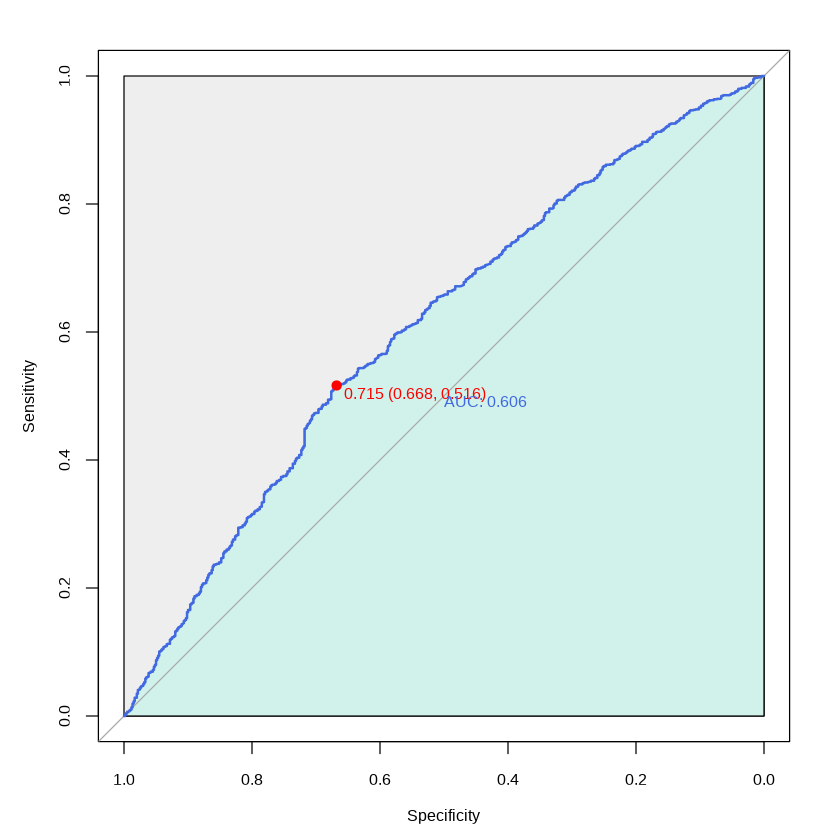

In [ ]:
pROC::plot.roc(roc_cutoff,
col="royalblue",
print.auc=TRUE,
max.auc.polygon=TRUE,
print.thres=TRUE, print.thres.pch=19, print.thres.col = "red",
auc.polygon=TRUE, auc.polygon.col="#D1F2EB")
roc_cutoff_value <- pROC::coords(roc_cutoff, "best", ret = "threshold", transpose = F)
roc_cutoff_value

In [ ]:
 roc_cutoff_value <- pROC::coords(roc_cutoff, "best", ret = "threshold", transpose = F)[1,1]
 cat("roc_cutoff_value: ",roc_cutoff_value)

roc_cutoff_value:  0.7153248

In [ ]:
# 우울증 예측을 위한 cutoff value 기준으로 1 또는 0로 변환
real_predict <- real_predict %>%
  mutate(predict_depression_cut = as.factor(ifelse(predict_value > roc_cutoff_value, 1, 0)))
# 결과 확인
tail(real_predict)

,History.of.depression,predict_value,predict_depression_cut
,<fct>,<dbl>,<fct>
19955,1,0.7686279,1
19969,1,0.7622330,1
19983,1,0.5819602,0
19984,1,0.7878957,1
19987,1,0.7767447,1
19991,1,0.6138065,0


In [ ]:
# 혼동행렬 작성
conf_matrix <- confusionMatrix(real_predict$History.of.depression, real_predict$predict_depression_cut)
# 결과 출력
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 400 199
         1 677 723
                                          
               Accuracy : 0.5618          
                 95% CI : (0.5397, 0.5837)
    No Information Rate : 0.5388          
    P-Value [Acc > NIR] : 0.0205          
                                          
                  Kappa : 0.15            
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.3714          
            Specificity : 0.7842          
         Pos Pred Value : 0.6678          
         Neg Pred Value : 0.5164          
             Prevalence : 0.5388          
         Detection Rate : 0.2001          
   Detection Prevalence : 0.2996          
      Balanced Accuracy : 0.5778          
                                          
       'Positive' Class : 0               
                              

# Decision Tree

In [ ]:
install.packages("rpart")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(rpart)

In [ ]:
dtm_depress <- rpart(formula = History.of.depression ~ .,
                     data = train_depress,
                     method = "class",
                     control = rpart.control(cp = 0.0004
                     ))
summary(dtm_depress)

Call:
rpart(formula = History.of.depression ~ ., data = train_depress, 
    method = "class", control = rpart.control(cp = 4e-04))
  n= 18000 

            CP nsplit rel error   xerror       xstd
1 0.0004938272      0 1.0000000 1.000000 0.01138550
2 0.0004814815     56 0.9596296 1.012778 0.01142659
3 0.0004629630     61 0.9572222 1.015741 0.01143599
4 0.0004444444     67 0.9542593 1.018704 0.01144533
5 0.0004166667     72 0.9520370 1.023889 0.01146157
6 0.0004012346     83 0.9470370 1.034815 0.01149527
7 0.0004000000     93 0.9422222 1.034815 0.01149527

Variable importance
                     Income고소득층                   Employment.Status 
                                 25                                   8 
                 Number.of.Children            X.Smoking.Status.Current 
                                  6                                   5 
                     Income중소득층                      Income저소득층 
                                  4                               

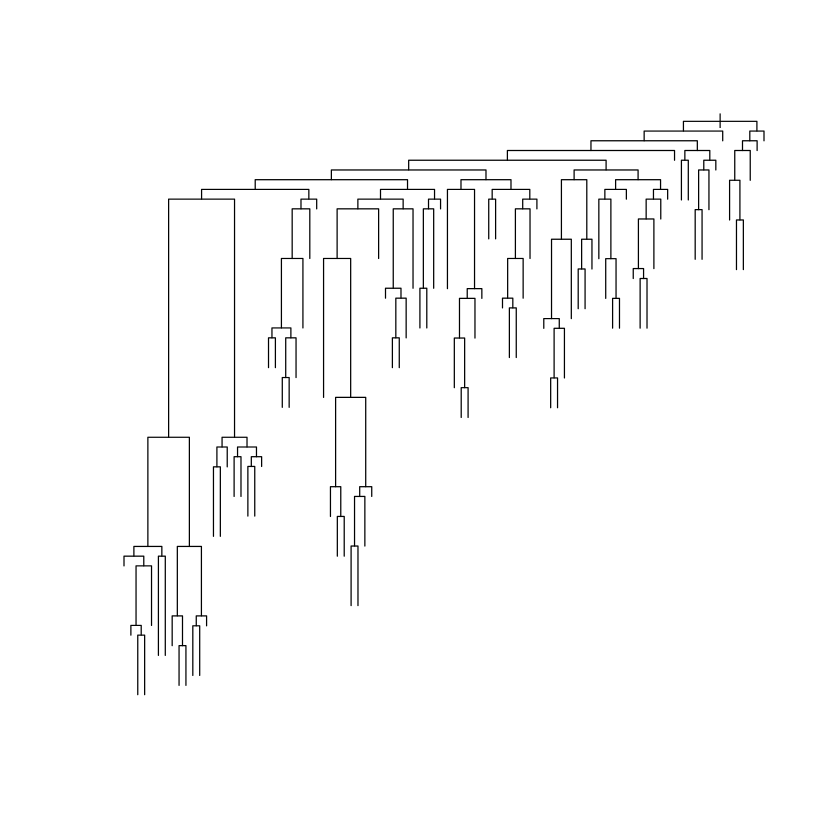

In [ ]:
plot(dtm_depress)
#text(dtm_depress,use.n = TRUE)

In [ ]:
rpart::printcp(dtm_depress)


Classification tree:
rpart(formula = History.of.depression ~ ., data = train_depress, 
    method = "class", control = rpart.control(cp = 4e-04))

Variables actually used in tree construction:
 [1] Age                                 Alcohol.Consumption                
 [3] Chronic.Medical.Conditions          Employment.Status                  
 [5] Family.History.of.Depression        History.of.Substance.Abuse         
 [7] Income고소득층                      Number.of.Children                 
 [9] X.Dietary.Habits.Healthy            X.Dietary.Habits.Moderate          
[11] X.Dietary.Habits.Unhealthy          X.Education.Level.Associate.Degree 
[13] X.Education.Level.Bachelor.s.Degree X.Education.Level.Master.s.Degree  
[15] X.Education.Level.PhD               X.Marital.Status.Divorced          
[17] X.Marital.Status.Married            X.Marital.Status.Single            
[19] X.Marital.Status.Widowed            X.Physical.Activity.Level.Active   
[21] X.Physical.Activity.Level.Moderate 

In [ ]:
dtm_depress$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.0004938272,0,1.0000000,1.000000,0.01138550
2,0.0004814815,56,0.9596296,1.012778,0.01142659
3,0.0004629630,61,0.9572222,1.015741,0.01143599
4,0.0004444444,67,0.9542593,1.018704,0.01144533
5,0.0004166667,72,0.9520370,1.023889,0.01146157
6,0.0004012346,83,0.9470370,1.034815,0.01149527
7,0.0004000000,93,0.9422222,1.034815,0.01149527


In [ ]:
min_xerror_cp <-
  dtm_depress$cptable %>%
    as_tibble() %>%
    filter(xerror ==  min(xerror)) %>%
      pull(CP)
cat("min_xerror_cp =", min_xerror_cp)
str(min_xerror_cp)

min_xerror_cp = 0.0004938272 num 0.000494


In [ ]:
dtm_pr_depress <-
  rpart::prune(dtm_depress, cp = 0.0004629630)

summary(dtm_pr_depress)

Call:
rpart(formula = History.of.depression ~ ., data = train_depress, 
    method = "class", control = rpart.control(cp = 4e-04))
  n= 18000 

            CP nsplit rel error   xerror       xstd
1 0.0004938272      0 1.0000000 1.000000 0.01138550
2 0.0004814815     56 0.9596296 1.012778 0.01142659
3 0.0004629630     61 0.9572222 1.015741 0.01143599

Variable importance
                     Income고소득층            X.Smoking.Status.Current 
                                 38                                   8 
                 Number.of.Children   X.Education.Level.Master.s.Degree 
                                  5                                   5 
                Alcohol.Consumption            X.Marital.Status.Married 
                                  4                                   3 
       Family.History.of.Depression X.Education.Level.Bachelor.s.Degree 
                                  3                                   3 
          X.Dietary.Habits.Moderate           X

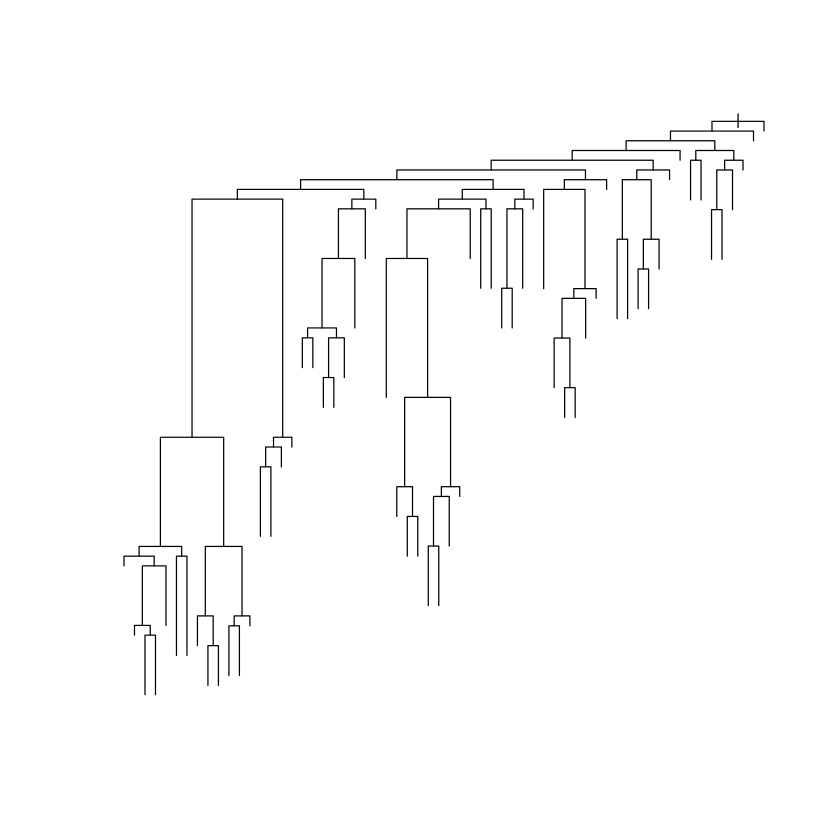

In [ ]:
plot(dtm_pr_depress)
#text(dtm_pr_depress,use.n = TRUE)

In [ ]:
predict_value <-
  predict(dtm_pr_depress, test_depress, type = "class") %>%
    tibble(predict_value = .)

predict_value %>% show()

# A tibble: 1,999 × 1
   predict_value
   <fct>        
 1 1            
 2 1            
 3 1            
 4 1            
 5 1            
 6 1            
 7 1            
 8 1            
 9 1            
10 1            
# ℹ 1,989 more rows


In [ ]:
# 11번
real_predict <- test_depress %>%
    select(History.of.depression) %>%
    dplyr::bind_cols(.,predict_value)

real_predict

,History.of.depression,predict_value
,<fct>,<fct>
16,0,1
22,0,1
24,0,1
72,0,1
81,0,1
82,0,1
96,0,1
124,0,1
128,0,1


In [ ]:
# 12번
caret::confusionMatrix(real_predict$History.of.depression, real_predict$predict_value) # 1이 F 0이 T

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0   36  563
         1   54 1346
                                          
               Accuracy : 0.6913          
                 95% CI : (0.6706, 0.7116)
    No Information Rate : 0.955           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0284          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.40000         
            Specificity : 0.70508         
         Pos Pred Value : 0.06010         
         Neg Pred Value : 0.96143         
             Prevalence : 0.04502         
         Detection Rate : 0.01801         
   Detection Prevalence : 0.29965         
      Balanced Accuracy : 0.55254         
                                          
       'Positive' Class : 0               
                        

# Random Forest

In [ ]:
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(randomForest)

In [ ]:
sqrt(32)

[1] 5.656854

In [ ]:
rfm_depress <- randomForest(History.of.depression~., data = train_depress,
na.action = na.omit,importance = T,mtry=4, ntree = 1000)
rfm_depress


Call:
 randomForest(formula = History.of.depression ~ ., data = train_depress,      importance = T, mtry = 4, ntree = 1000, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 4

        OOB estimate of  error rate: 30.09%
Confusion matrix:
    0     1 class.error
0 286  5114  0.94703704
1 303 12297  0.02404762

In [ ]:
predict_value_rf <-
  predict(rfm_depress, newdata = test_depress, type = "class")%>%
  tibble(predict_value_rf = .)
predict_value_rf

predict_value_rf
<fct>
1
1
1
1
1
1
1
1
1


In [ ]:
real_predict_rf <-
  test_depress %>%
    select(History.of.depression) %>%
      dplyr::bind_cols(.,predict_value_rf)

real_predict_rf

,History.of.depression,predict_value_rf
,<fct>,<fct>
16,0,1
22,0,1
24,0,1
72,0,1
81,0,1
82,0,1
96,0,1
124,0,1
128,0,1


In [ ]:
# 13번
cm <- caret::confusionMatrix(
  real_predict_rf$History.of.depression,
  real_predict_rf$predict_value_rf
)
cm

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0   29  570
         1   29 1371
                                          
               Accuracy : 0.7004          
                 95% CI : (0.6797, 0.7204)
    No Information Rate : 0.971           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0373          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.50000         
            Specificity : 0.70634         
         Pos Pred Value : 0.04841         
         Neg Pred Value : 0.97929         
             Prevalence : 0.02901         
         Detection Rate : 0.01451         
   Detection Prevalence : 0.29965         
      Balanced Accuracy : 0.60317         
                                          
       'Positive' Class : 0               
                        

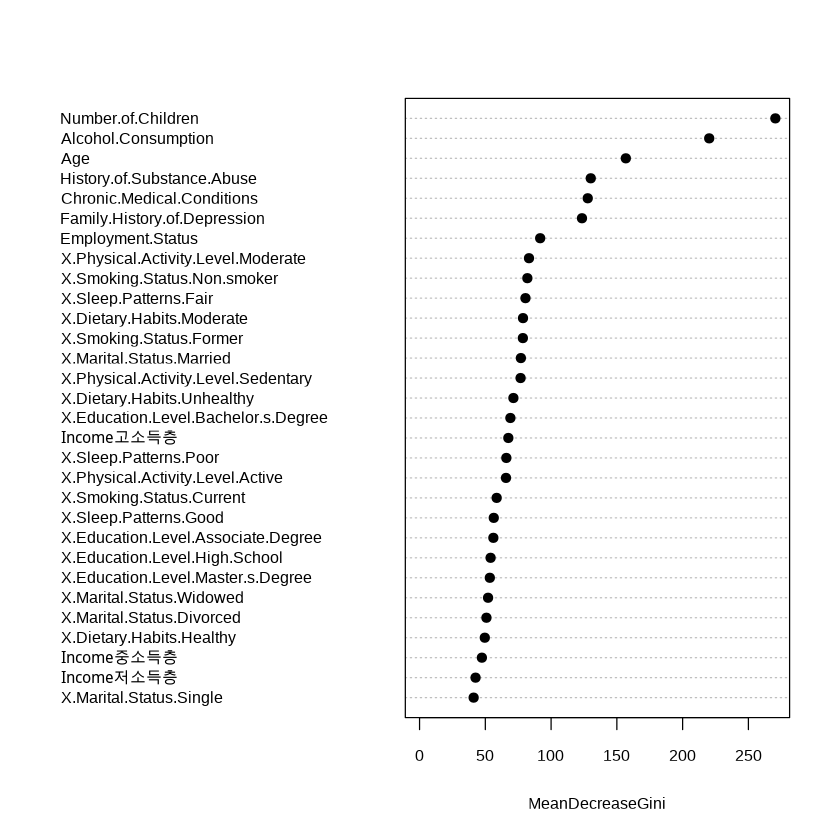

In [ ]:
varImpPlot(rfm_depress, type = 2, pch = 19, col = 1, cex = 1, main = "")

In [ ]:
importance(rfm_depress)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
Age,-19.41142660,38.996018,29.748505,156.82593
Number.of.Children,-14.59438890,38.189250,31.994218,270.50602
Employment.Status,9.18530676,32.393692,37.276085,91.70627
Alcohol.Consumption,0.44396185,20.622178,18.539583,220.20764
History.of.Substance.Abuse,-0.56648313,12.341657,9.752353,130.16008
Family.History.of.Depression,0.09293063,17.633435,15.655122,123.48293
Chronic.Medical.Conditions,7.08174801,12.112745,14.119116,127.86104
X.Education.Level.Associate.Degree,2.32667124,11.697504,16.306970,56.10606
X.Education.Level.Bachelor.s.Degree,-14.25666103,27.702640,25.269896,69.05840
X.Education.Level.High.School,-5.14685575,22.660582,26.866496,54.01035
